In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tabulate import tabulate
import yaml

In [13]:
print(tabulate([['Hierarchical Self Attention Based Human Activity Recognition and Novel Activity Detection']], [], tablefmt="fancy_grid"))

╒═══════════════════════════════════════════════════════════════════════════════════════════╕
│ Hierarchical Self Attention Based Human Activity Recognition and Novel Activity Detection │
╘═══════════════════════════════════════════════════════════════════════════════════════════╛


In [3]:
!nvidia-smi

Wed Sep  2 11:29:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   44C    P8    18W / 300W |     22MiB / 11016MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1



## Data Download

In [5]:
# !wget -q -O clean_mex_data.csv https://www.dropbox.com/s/h22cg25jszu2360/clean_mex_data.csv?dl=1

In [6]:
df = pd.read_csv('../data/clean_realdisp_data.csv')

In [7]:
df = df[df['DISPLACEMENT'].isin(['ideal', 'self'])]
df = df.sort_values(by=['SUBJECT', 'LABEL', 'TIME_SECOND', 'TIME_MICROSECOND'], ignore_index=True)

In [8]:
SENSOR_PLACEMENT = ['RLA', 'RUA', 'BACK', 'LUA', 'LLA', 'RC', 'RT', 'LT', 'LC']
# SENSOR_LIST = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYR_X', 'GYR_Y', 'GYR_Z', 
#                'MAG_X', 'MAG_Y', 'MAG_Z', 'QUAT_1', 'QUAT_2', 'QUAT_3', 'QUAT_4']

SENSOR_LIST = ['ACC_X', 'ACC_Y', 'ACC_Z', 'GYR_X', 'GYR_Y', 'GYR_Z', 
               'MAG_X', 'MAG_Y', 'MAG_Z', 'QUAT_1', 'QUAT_2', 'QUAT_3', 'QUAT_4']

FEATURES = list()

for loc in SENSOR_PLACEMENT:
    for sensor in SENSOR_LIST:
        FEATURES.append(str(loc + '_' + sensor))

LABELS = 'LABEL'

In [9]:
print(len(FEATURES))
print(FEATURES)

117
['RLA_ACC_X', 'RLA_ACC_Y', 'RLA_ACC_Z', 'RLA_GYR_X', 'RLA_GYR_Y', 'RLA_GYR_Z', 'RLA_MAG_X', 'RLA_MAG_Y', 'RLA_MAG_Z', 'RLA_QUAT_1', 'RLA_QUAT_2', 'RLA_QUAT_3', 'RLA_QUAT_4', 'RUA_ACC_X', 'RUA_ACC_Y', 'RUA_ACC_Z', 'RUA_GYR_X', 'RUA_GYR_Y', 'RUA_GYR_Z', 'RUA_MAG_X', 'RUA_MAG_Y', 'RUA_MAG_Z', 'RUA_QUAT_1', 'RUA_QUAT_2', 'RUA_QUAT_3', 'RUA_QUAT_4', 'BACK_ACC_X', 'BACK_ACC_Y', 'BACK_ACC_Z', 'BACK_GYR_X', 'BACK_GYR_Y', 'BACK_GYR_Z', 'BACK_MAG_X', 'BACK_MAG_Y', 'BACK_MAG_Z', 'BACK_QUAT_1', 'BACK_QUAT_2', 'BACK_QUAT_3', 'BACK_QUAT_4', 'LUA_ACC_X', 'LUA_ACC_Y', 'LUA_ACC_Z', 'LUA_GYR_X', 'LUA_GYR_Y', 'LUA_GYR_Z', 'LUA_MAG_X', 'LUA_MAG_Y', 'LUA_MAG_Z', 'LUA_QUAT_1', 'LUA_QUAT_2', 'LUA_QUAT_3', 'LUA_QUAT_4', 'LLA_ACC_X', 'LLA_ACC_Y', 'LLA_ACC_Z', 'LLA_GYR_X', 'LLA_GYR_Y', 'LLA_GYR_Z', 'LLA_MAG_X', 'LLA_MAG_Y', 'LLA_MAG_Z', 'LLA_QUAT_1', 'LLA_QUAT_2', 'LLA_QUAT_3', 'LLA_QUAT_4', 'RC_ACC_X', 'RC_ACC_Y', 'RC_ACC_Z', 'RC_GYR_X', 'RC_GYR_Y', 'RC_GYR_Z', 'RC_MAG_X', 'RC_MAG_Y', 'RC_MAG_Z', 'RC_QUAT_

In [5]:
activity_file = open('../data/realdisp_activity.yaml', mode='r')
activity_dict = yaml.load(activity_file, Loader=yaml.FullLoader)
activity_map = activity_dict['activity']

print(activity_map)

{1: 'Walking (1 min)', 2: 'Jogging (1 min)', 3: 'Running (1 min)', 4: 'Jump up (20x)', 5: 'Jump front & back (20x)', 6: 'Jump sideways (20x)', 7: 'Jump leg/arms open/closed (20x)', 8: 'Jump rope (20x)', 9: 'Trunk twist (arms outstretched) (20x)', 10: 'Trunk twist (elbows bended) (20x)', 11: 'Waist bends forward (20x)', 12: 'Waist rotation (20x)', 13: 'Waist bends (reach foot with opposite hand) (20x)', 14: 'Reach heels backwards (20x)', 15: 'Lateral bend (10x to the left + 10x to the right)', 16: 'Lateral bend arm up (10x to the left + 10x to the right)', 17: 'Repetitive forward stretching (20x)', 18: 'Upper trunk and lower body opposite twist (20x)', 19: 'Arms lateral elevation (20x)', 20: 'Arms frontal elevation (20x)', 21: 'Frontal hand claps (20x)', 22: 'Arms frontal crossing (20x)', 23: 'Shoulders high amplitude rotation (20x)', 24: 'Shoulders low amplitude rotation (20x)', 25: 'Arms inner rotation (20x)', 26: 'Knees (alternatively) to the breast (20x)', 27: 'Heels (alternatively)

In [6]:
import json

with open("activities/realdisp_activity.json", "w") as outfile:  
    json.dump(activity_map, outfile, indent = 4) 

In [79]:
def get_activity_dict(activity_map:dict, novel_classes:list):
    _activity_map = activity_map.copy()
    novel_map = dict()
    
    for activity_class in novel_classes:
        novel_map[activity_class] = activity_map[activity_class]
        _activity_map.pop(activity_class)
        
    return _activity_map, novel_map

In [80]:
# 2: 'Jogging (1 min)', 8: 'Jump rope (20x)', 12: 'Waist rotation (20x)', 16: 'Lateral bend arm up (10x to the left + 10x to the right)'
NOVEL_CLASSES = [2, 8, 12, 16]

In [81]:
_activity_map, novel_map = get_activity_dict(activity_map, NOVEL_CLASSES)

print(_activity_map)
print(novel_map)

{1: 'Walking (1 min)', 3: 'Running (1 min)', 4: 'Jump up (20x)', 5: 'Jump front & back (20x)', 6: 'Jump sideways (20x)', 7: 'Jump leg/arms open/closed (20x)', 9: 'Trunk twist (arms outstretched) (20x)', 10: 'Trunk twist (elbows bended) (20x)', 11: 'Waist bends forward (20x)', 13: 'Waist bends (reach foot with opposite hand) (20x)', 14: 'Reach heels backwards (20x)', 15: 'Lateral bend (10x to the left + 10x to the right)', 17: 'Repetitive forward stretching (20x)', 18: 'Upper trunk and lower body opposite twist (20x)', 19: 'Arms lateral elevation (20x)', 20: 'Arms frontal elevation (20x)', 21: 'Frontal hand claps (20x)', 22: 'Arms frontal crossing (20x)', 23: 'Shoulders high amplitude rotation (20x)', 24: 'Shoulders low amplitude rotation (20x)', 25: 'Arms inner rotation (20x)', 26: 'Knees (alternatively) to the breast (20x)', 27: 'Heels (alternatively) to the backside (20x)', 28: 'Knees bending (crouching) (20x)', 29: 'Knees (alternatively) bend forward (20x)', 30: 'Rotation on the kne

### Scaling

In [15]:
# df[FEATURES] = df[FEATURES] / 100
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [16]:
holdout_data = df.loc[df['LABEL'].isin(NOVEL_CLASSES)]
novel_data = holdout_data.copy().reset_index(drop=True)

df = df.drop(holdout_data.copy().index)
df = df.reset_index(drop=True)

### Train test split

<AxesSubplot:xlabel='SUBJECT', ylabel='count'>

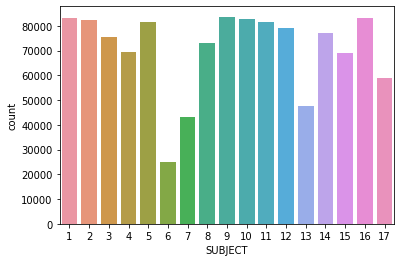

In [17]:
sns.countplot(x='SUBJECT', data=df)

In [18]:
train_sub = set(range(1, 18))
test_sub = set([6])

train_sub = train_sub - test_sub

In [19]:
train_sub

{1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [20]:
train_df = df[df['SUBJECT'].isin(train_sub)]
test_df = df[df['SUBJECT'].isin(test_sub)]

In [21]:
print(train_df.shape)
print(test_df.shape)

(1170593, 122)
(24918, 122)


## windowing

In [22]:
WINDOW_SIZE=750
STRIDE = 250

In [23]:
def create_windowed_dataset(df, features= FEATURES, class_label = LABELS, window_size=2000, stride = 300):
    X = df[features].values
    y = df[class_label].values
    segments = []
    labels = []

    seg_start= 0
    seg_end = window_size
    while seg_end <= len(X):
        if len(np.unique(y[seg_start:seg_end])) == 1: #valid-window
            segments.append(X[seg_start:seg_end])
            labels.append(y[seg_start]) # doesn't matter all same labels

            seg_start += stride
            seg_end = seg_start + window_size

        else: #mixed- discard last few samples, move start to the new activity
            current_label = y[seg_start]
            for i in range(seg_start, seg_end):
                if y[i] != current_label:
                    seg_start = i
                    seg_end = seg_start + window_size
                    break

    return np.asarray(segments).astype(np.float32), np.asarray(labels)

In [24]:
X_train, y_train = create_windowed_dataset(train_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
X_test, y_test = create_windowed_dataset(test_df,FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
X_holdout, y_holdout = create_windowed_dataset(novel_data, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)

In [25]:
N_WINDOW = 15
N_TIMESTEP = 50

In [26]:
X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_holdout = X_holdout.reshape((X_holdout.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=33)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=33)
y_holdout = tf.keras.utils.to_categorical(y_holdout-1, num_classes=33)

In [27]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_holdout.shape)
print(y_holdout.shape)

(3547, 15, 50, 117)
(3547, 33)
(57, 15, 50, 117)
(57, 33)
(557, 15, 50, 117)
(557, 33)


In [28]:
np.unique(np.argmax(y_test, axis=1))

array([ 0,  2,  4,  5,  6,  8,  9, 10, 22, 24, 27, 28, 29, 30])

## Attention Model

In [29]:
class AttentionWithContext(tf.keras.layers.Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False):
        super(AttentionWithContext, self).__init__()

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.u_regularizer = tf.keras.regularizers.get(u_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.u_constraint = tf.keras.constraints.get(u_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = tf.keras.activations.tanh(uit)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = tf.math.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, tf.keras.backend.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= tf.cast(tf.keras.backend.sum(a, axis=1, keepdims=True) + tf.keras.backend.epsilon(), tf.keras.backend.floatx())

        a = tf.keras.backend.expand_dims(a)
        weighted_input = x * a
        result = tf.keras.backend.sum(weighted_input, axis=1)

        if self.return_attention:
            return result, a
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return tf.TensorShape([input_shape[0].value, input_shape[-1].value],[input_shape[0].value, input_shape[1].value])
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])

In [30]:
class AggregateAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(AggregateAttention, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.d_model = d_model
        self.query = self.add_weight("learned_query",
                                     shape=[1, 1, self.d_model],
                                     initializer=tf.keras.initializers.Orthogonal())  
    
    def call(self, v, k):
        batched_query = tf.tile(self.query, [tf.shape(v)[0],1,1])
        output, attention_weights = self.mha(v, k, batched_query, mask=None)
        output = tf.squeeze(output, axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=2)
        return output, attention_weights

### Self Attention

In [31]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model, include_dropout=True, dropout_rate=0.2):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.include_dropout = include_dropout
        if include_dropout:
            self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, x):
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[:, :tf.shape(x)[1], :]
        if self.include_dropout:
            x = self.dropout(x)
        return x

In [32]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [33]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model,use_bias=False)
        self.wk = tf.keras.layers.Dense(d_model,use_bias=True)
        self.wv = tf.keras.layers.Dense(d_model,use_bias=True)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
            
        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [34]:
class SelfAttentionBlock(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(SelfAttentionBlock, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [35]:
class CombinedSensorSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate, concat=True):
        super(CombinedSensorSelfAttention, self).__init__()
        self.concat = concat
        self.agr_attn = AggregateAttention(d_model, num_heads)
        self.ffn1 = point_wise_feed_forward_network(d_model, dff)
        self.ffn2 = point_wise_feed_forward_network(d_model, dff)
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    
    def call(self, x):
        if self.concat:
            x = tf.concat(x, axis=1)
        x = self.ffn1(x)
        x, attn_score = self.agr_attn(x, x)
        x = self.dropout1(x)
        ffn_output = self.ffn2(x)  # (batch_size, d_model)
        ffn_output = self.dropout2(ffn_output)
        out = self.layernorm(ffn_output + x)  # (batch_size, d_model)
        return out, attn_score

In [36]:
class DataTransform(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(DataTransform, self).__init__()
        # self.ln = tf.keras.layers.LayerNormalization()
        self.conv_1d = tf.keras.layers.Conv1D(d_model, 1, activation='relu')
    
    def call(self, x):
        # x = self.ln(x)
        x = self.conv_1d(x)
        return x

In [37]:
class ModalityEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, n_timesteps, d_model, num_heads, dff, num_sa_blocks=2, dropout_rate=0.1):
        super(ModalityEncoderBlock, self).__init__()
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.look_ahead_mask = create_look_ahead_mask(n_timesteps)
        self.data_transform = DataTransform(d_model)
        self.pe = PositionalEncoding(n_timesteps, d_model, dropout_rate=dropout_rate)
        self.num_sa_blocks = num_sa_blocks
        self.self_attn_blocks = [ SelfAttentionBlock(d_model, num_heads, dff, dropout_rate)
                                        for _ in range(self.num_sa_blocks)]
        # self.agr_attn = AttentionWithContext(return_attention=True)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.data_transform(x)
        x = self.pe(x)
        for i in range(self.num_sa_blocks):
            # x = self.self_attn_blocks[i](x, mask=self.look_ahead_mask)
            x = self.self_attn_blocks[i](x)
        # x, attn_score = self.agr_attn(x)
        # return x, attn_score
        return x


    # def compute_output_shape(x, input_shape):
    #     return tf.TensorShape([input_shape, self.d_model])

In [38]:
def get_modality_encoder(modality_indices, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
    model = tf.keras.Model(inputs=inputs, outputs=modality_outputs)
    return model

In [39]:
class MultiWindowEncoder(tf.keras.layers.Layer):
    def __init__(self, modality_indices, n_window, n_timesteps,n_features,n_outputs, d_model, num_heads, dff, dropout_rate=0.1):
        super(MultiWindowEncoder, self).__init__()
        self.n_window = n_window
        self.d_model = d_model
        self.n_timesteps = n_timesteps
        self.window_encoder = get_modality_encoder(modality_indices,n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs, d_model=d_model, num_heads = num_heads, dff=dff, dropout_rate=dropout_rate)
        self.combined_sensor_attn = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate)
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        feature_dim = tf.shape(x)[-1]
        x = tf.reshape(x, (-1, self.n_timesteps, feature_dim)) # all sessions in batch dim
        x = self.window_encoder(x)
        x, attn_scores = self.combined_sensor_attn(x)
        x = tf.reshape(x, (batch_size, -1, self.d_model))
        attn_scores = tf.reshape(attn_scores, (batch_size, -1, self.n_timesteps))
        return x, attn_scores

In [40]:
def get_modality_model(modality_indices, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    num_modality = len(modality_indices)-1
    inputs = tf.keras.layers.Input(shape=(n_timesteps,n_features,))
    attn_scores = []
    modality_outputs = []
    for i in range(num_modality):
            modality_x = inputs[:, :, modality_indices[i]:modality_indices[i+1] ]
            # modality_x, attn_score = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=nh, dff=dff, num_sa_blocks=2)(modality_x)
            # modality_outputs.append(modality_x)
            modality_x = ModalityEncoderBlock(n_timesteps=n_timesteps, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(modality_x)
            modality_outputs.append(modality_x)
            # attn_score = tf.keras.layers.Flatten() (attn_score)
            # attn_scores.append(attn_score)
    x, _ = CombinedSensorAttention() (modality_outputs)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

In [41]:
def get_modality_model_w_time_hierarchy(modality_indices,n_window, n_timesteps, n_features, n_outputs,dff = 512,d_model=128,num_heads = 4,dropout_rate=0.2):
    inputs = tf.keras.layers.Input(shape=(n_window, n_timesteps,n_features,))
    x, _ = MultiWindowEncoder(modality_indices, n_window, n_timesteps,n_features,n_outputs, d_model, num_heads, dff, dropout_rate=0.1) (inputs)
    x = ModalityEncoderBlock(n_timesteps=n_window, d_model=d_model, num_heads=num_heads, dff=dff, num_sa_blocks=2, dropout_rate=dropout_rate)(x)
    x, _ = CombinedSensorSelfAttention(d_model, 1, dff, dropout_rate, concat=False) (x)
    predictions = tf.keras.layers.Dense(n_outputs, activation='softmax') (x)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model

## Training

In [42]:
list(range(0, 118, 13))

[0, 13, 26, 39, 52, 65, 78, 91, 104, 117]

In [43]:
tf.keras.backend.clear_session()

n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
model = get_modality_model_w_time_hierarchy(list(range(0, 118, 13)),n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
          optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 50, 117)]     0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 989568    
_________________________________________________________________
modality_encoder_block_9 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
_________________________________________________________________
dense_136 (Dense)            (None, 33)                2145      
Total params: 1,178,657
Trainable params: 1,178,657
Non-trainable params: 0
_________________________________________________________________


In [44]:
verbose, epochs, batch_size = 1, 75, 64
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,verbose=1, mode='max')
#mcp_save = ModelCheckpoint('test_3_best.hdf5', save_best_only=True, monitor='val_acc', mode='max')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4, mode='min')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1, use_multiprocessing=True)

Epoch 1/75
50/50 [==============================] - 14s 270ms/step - loss: 2.9160 - accuracy: 0.1939 - val_loss: 2.5025 - val_accuracy: 0.2282
Epoch 2/75
50/50 [==============================] - 10s 209ms/step - loss: 1.6887 - accuracy: 0.4586 - val_loss: 1.9631 - val_accuracy: 0.4113
Epoch 3/75
50/50 [==============================] - 10s 209ms/step - loss: 1.1599 - accuracy: 0.6040 - val_loss: 1.8759 - val_accuracy: 0.4676
Epoch 4/75
50/50 [==============================] - 10s 210ms/step - loss: 0.8427 - accuracy: 0.7177 - val_loss: 1.5757 - val_accuracy: 0.5211
Epoch 5/75
50/50 [==============================] - 10s 209ms/step - loss: 0.6791 - accuracy: 0.7625 - val_loss: 1.6532 - val_accuracy: 0.5408
Epoch 6/75
50/50 [==============================] - 10s 210ms/step - loss: 0.5045 - accuracy: 0.8192 - val_loss: 1.8053 - val_accuracy: 0.5690
Epoch 7/75
50/50 [==============================] - 10s 210ms/step - loss: 0.5299 - accuracy: 0.8136 - val_loss: 1.7917 - val_accuracy: 0.6028

In [45]:
pred = model.predict(X_test, batch_size=64)

In [49]:
# out_f = open('result/realdisp/samplefile.txt', 'w') 

print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), labels=np.unique(np.argmax(y_test, axis=1)), target_names=list(_activity_map.values())))

                                                   precision    recall  f1-score   support

                                  Walking (1 min)       1.00      1.00      1.00        10
                                  Running (1 min)       1.00      1.00      1.00        10
                                    Jump up (20x)       1.00      1.00      1.00         1
                          Jump front & back (20x)       0.00      0.00      0.00         1
                              Jump sideways (20x)       1.00      1.00      1.00         4
                  Jump leg/arms open/closed (20x)       1.00      1.00      1.00         6
            Trunk twist (arms outstretched) (20x)       1.00      1.00      1.00         5
                Trunk twist (elbows bended) (20x)       1.00      1.00      1.00         5
                        Waist bends forward (20x)       1.00      1.00      1.00         1
Waist bends (reach foot with opposite hand) (20x)       1.00      1.00      1.00         

In [83]:
len(activity_map.values())

33

In [85]:
np.array(list(activity_map.values()))[np.unique(np.argmax(y_test, axis=1))].shape

(14,)

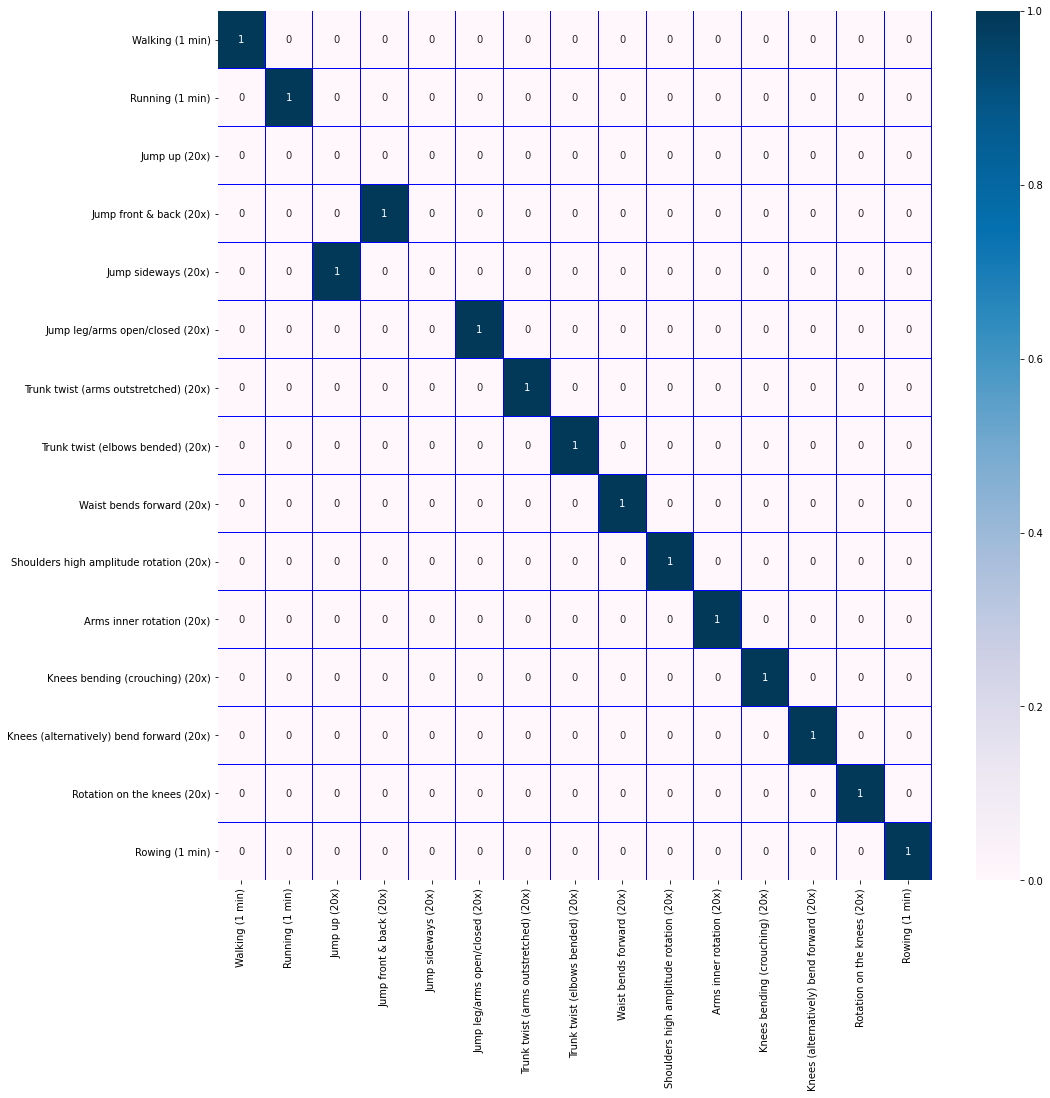

In [88]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), normalize='true')
activity_list = np.array(list(activity_map.values()))[np.union1d(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))]
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (16,16))
sns.heatmap(df_cm, annot=True, linewidths=0.05, linecolor='blue', cmap="PuBu")

plt.show()

# VAE [Novelty Detection]

In [89]:
for l in model.layers:
    print(l.name)

input_1
multi_window_encoder
modality_encoder_block_9
combined_sensor_self_attention_1
dense_136


In [90]:
hierarchical_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('combined_sensor_self_attention_1').output, name='hierarchical_encoder')
hierarchical_model.trainable = False

In [91]:
hierarchical_model.summary()

Model: "hierarchical_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 50, 117)]     0         
_________________________________________________________________
multi_window_encoder (MultiW ((None, None, 64), (None, 989568    
_________________________________________________________________
modality_encoder_block_9 (Mo (None, None, 64)          104000    
_________________________________________________________________
combined_sensor_self_attenti ((None, 64), (None, 1, No 82944     
Total params: 1,176,512
Trainable params: 0
Non-trainable params: 1,176,512
_________________________________________________________________


In [92]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(tf.keras.layers.Layer):

    def __init__(self, latent_dim=16, intermediate_dim=32, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        
        return z_mean, z_log_var, z


class Decoder(tf.keras.layers.Layer):

    def __init__(self, original_dim, intermediate_dim=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = tf.keras.layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = tf.keras.layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        
        return self.dense_output(x)

class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        base_model,
        original_dim,
        intermediate_dim=32,
        latent_dim=16,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.base_model = base_model
        
        self.original_dim = original_dim
        
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        inputs, _ = self.base_model(inputs)
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        
        return reconstructed

    def train_step(self, data):
        with tf.GradientTape() as tape:
            data, _ = self.base_model(data)
            z_mean, z_log_var, z = self.encoder(data)
            reconstructed = self.decoder(z)

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(data, reconstructed))
            
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [93]:
hsa_vae = VariationalAutoEncoder(base_model=hierarchical_model, original_dim=64)

In [94]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
hsa_vae.compile(optimizer)    

In [95]:
vae_history = hsa_vae.fit(X_train, epochs=50, batch_size=64)

Epoch 1/50
56/56 [==============================] - 4s 74ms/step - loss: 2.1294 - reconstruction_loss: 1.7245 - kl_loss: 0.4049
Epoch 2/50
56/56 [==============================] - 4s 74ms/step - loss: 1.6888 - reconstruction_loss: 1.6176 - kl_loss: 0.0712
Epoch 3/50
56/56 [==============================] - 4s 74ms/step - loss: 1.5922 - reconstruction_loss: 1.5579 - kl_loss: 0.0343
Epoch 4/50
56/56 [==============================] - 4s 74ms/step - loss: 1.5508 - reconstruction_loss: 1.5285 - kl_loss: 0.0223
Epoch 5/50
56/56 [==============================] - 4s 74ms/step - loss: 1.5313 - reconstruction_loss: 1.5144 - kl_loss: 0.0169
Epoch 6/50
56/56 [==============================] - 4s 74ms/step - loss: 1.5184 - reconstruction_loss: 1.5038 - kl_loss: 0.0146
Epoch 7/50
56/56 [==============================] - 4s 74ms/step - loss: 1.5118 - reconstruction_loss: 1.4974 - kl_loss: 0.0143
Epoch 8/50
56/56 [==============================] - 4s 74ms/step - loss: 1.5054 - reconstruction_loss: 1

## Novelty Result

In [96]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])

In [97]:
def kl_div(z_mean, z_log_var):
    kl_loss = -0.5 * tf.math.reduce_mean((z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1), axis=1)
    return kl_loss.numpy()

In [98]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_train)[0])
train_kl = kl_div(z_mean, z_log_var)

In [99]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_test)[0])
test_kl = kl_div(z_mean, z_log_var)

In [100]:
z_mean, z_log_var, z = hsa_vae.encoder(hierarchical_model.predict(X_holdout)[0])
holdout_kl = kl_div(z_mean, z_log_var)

In [101]:
def novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.25):
    threshold = np.mean(train_kl) - (mult * np.std(train_kl))
    
    y_holdout = (holdout_kl > threshold).astype(int)
    y_true = np.ones(shape=holdout_kl.shape, dtype=int)
    
    y_test_n = (test_kl > threshold).astype(int)
    _y_true = np.zeros(shape=test_kl.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
#     return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro')
    
    print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [113]:
novelty_eval_kl(train_kl, test_kl, holdout_kl, mult=0.35)

              precision    recall  f1-score   support

       KNOWN       0.25      0.23      0.24        57
       NOVEL       0.92      0.93      0.93       557

    accuracy                           0.87       614
   macro avg       0.59      0.58      0.58       614
weighted avg       0.86      0.87      0.86       614



In [103]:
train_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_train)[0], hsa_vae.predict(X_train)).numpy()
test_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_test)[0], hsa_vae.predict(X_test)).numpy()
novel_rec_loss = tf.keras.losses.mean_squared_error(hierarchical_model.predict(X_holdout)[0], hsa_vae.predict(X_holdout)).numpy()

In [104]:
def novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=0.25):
    threshold = np.mean(train_rec_loss) - (mult * np.std(train_rec_loss))
    
    y_holdout = (novel_rec_loss > threshold).astype(int)
    y_true = np.ones(shape=novel_rec_loss.shape, dtype=int)
    
    y_test_n = (test_rec_loss > threshold).astype(int)
    _y_true = np.zeros(shape=test_rec_loss.shape, dtype=int)
    
    y_holdout = np.append(y_holdout, y_test_n)
    y_true = np.append(y_true, _y_true)
    
    return accuracy_score(y_true, y_holdout), f1_score(y_true, y_holdout, average='macro'), 
    
#     print(classification_report(y_true, y_holdout, labels=[0, 1], target_names=['KNOWN', 'NOVEL']))

In [111]:
def hparam_search():
    table = list()
    thresh_vals = list(np.arange(0.51, 1.01, 0.01))
    
    idx = 0
    
    for m_val in thresh_vals:
        result = novelty_eval_reconstrunction(train_rec_loss, test_rec_loss, novel_rec_loss, mult=m_val)
        table.append([idx, m_val, result[0], result[1]])
        
        idx = idx + 1
    
    table = np.array(table)
    sns.lineplot(table[:, 1], table[:, 2], label='Accuracy')
    sns.lineplot(table[:, 1], table[:, 3], label='Macro F1')
    plt.xlabel('Hyperparameter Value')
    plt.title('Novelty Detection Experiement')
    plt.show()
    
    top_acc = np.array(pd.Series(table[:, 2]).nlargest().index)
    top_f1 = np.array(pd.Series(table[:, 3]).nlargest().index)
    
    print('Index with Top Accuracy and Macro F1 : ', top_acc, top_f1)
    print('Most Important Index : ', np.intersect1d(top_acc, top_f1))
    
    print(tabulate(table, headers=['Index', 'Std. Multiplier Value', 'Accuracy', 'Macro F1'], tablefmt="grid"))

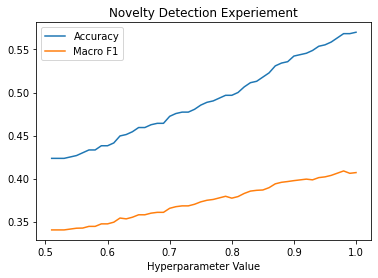

Index with Top Accuracy and Macro F1 :  [49 47 48 46 45] [47 49 46 48 45]
Most Important Index :  [45 46 47 48 49]
+---------+-------------------------+------------+------------+
|   Index |   Std. Multiplier Value |   Accuracy |   Macro F1 |
+=========+=========================+============+============+
|       0 |                    0.51 |   0.423453 |   0.34029  |
+---------+-------------------------+------------+------------+
|       1 |                    0.52 |   0.423453 |   0.34029  |
+---------+-------------------------+------------+------------+
|       2 |                    0.53 |   0.423453 |   0.34029  |
+---------+-------------------------+------------+------------+
|       3 |                    0.54 |   0.425081 |   0.34128  |
+---------+-------------------------+------------+------------+
|       4 |                    0.55 |   0.42671  |   0.342268 |
+---------+-------------------------+------------+------------+
|       5 |                    0.56 |   0.429967 |   

In [112]:
# Result
hparam_search() 

## LOSO Experiment

In [ ]:
def run_experiment(df, FEATURES, WINDOW_SIZE, STRIDE, BATCH_SIZE, N_WINDOW, N_TIMESTEP, sub_start=1):

    for i in range(sub_start, df['SUBJECT'].nunique() + 1):
        
        train_sub = set(range(1, df['SUBJECT'].nunique() + 1))
        test_sub = set([i])
        train_sub = train_sub - test_sub
        
        print('TEST SUBJECTS : ', test_sub)
        print('TRAIN SUBJECTS : ', train_sub)
        
        train_df = df[df['SUBJECT'].isin(train_sub)]
        test_df = df[df['SUBJECT'].isin(test_sub)]

        X_train, y_train = create_windowed_dataset(train_df, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
        X_test, y_test = create_windowed_dataset(test_df, FEATURES, window_size=WINDOW_SIZE, stride = STRIDE)
        
        X_train = X_train.reshape((X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
        X_test = X_test.reshape((X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

        y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=df['LABEL'].nunique())
        y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=df['LABEL'].nunique())
        
        tf.keras.backend.clear_session()

        n_window, n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]

        model = get_modality_model_w_time_hierarchy(list(range(0, 118, 13)),n_window, n_timesteps, n_features, n_outputs, d_model=64, num_heads = 2, dff=256)
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')

        verbose, epochs, batch_size = 2, 80, BATCH_SIZE
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.0, use_multiprocessing=True)
            
        pred = model.predict(X_test, batch_size=BATCH_SIZE)
        
        out_res = open(os.path.join('result/realdisp', str('subject___' + str(i).zfill(2) + '.txt')), 'w')
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), labels=np.unique(np.argmax(y_test, axis=1)),
                                    target_names=list(activity_map.values()), zero_division=1), file=out_res)
        print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), 
                                    labels=np.unique(np.argmax(y_test, axis=1)), target_names=list(activity_map.values()), zero_division=1))
        out_res.close()
        
        confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1), normalize='true')
        activity_list = np.array(list(activity_map.values()))[np.union1d(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))]
        df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
        plt.figure(figsize = (16,16))
        sns.heatmap(df_cm, annot=True, linewidths=0.05, linecolor='blue', cmap="PuBu")
        
        out_fig = 'subject___' + str(i).zfill(2) + '.png'
        plt.savefig(os.path.join('figures/realdisp', out_fig))

        plt.show()


TEST SUBJECTS :  {6}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Epoch 1/100
58/58 [==============================] - 16s 268ms/step - loss: 3.4408 - accuracy: 0.0678 - val_loss: 3.4517 - val_accuracy: 0.0244
Epoch 2/100
58/58 [==============================] - 13s 221ms/step - loss: 3.0662 - accuracy: 0.1511 - val_loss: 2.7366 - val_accuracy: 0.2488
Epoch 3/100
58/58 [==============================] - 13s 220ms/step - loss: 2.1361 - accuracy: 0.2941 - val_loss: 2.3047 - val_accuracy: 0.3171
Epoch 4/100
58/58 [==============================] - 13s 222ms/step - loss: 1.8740 - accuracy: 0.3307 - val_loss: 2.2698 - val_accuracy: 0.2512
Epoch 5/100
58/58 [==============================] - 13s 222ms/step - loss: 1.5897 - accuracy: 0.4094 - val_loss: 1.9200 - val_accuracy: 0.3171
Epoch 6/100
58/58 [==============================] - 13s 222ms/step - loss: 1.3574 - accuracy: 0.4940 - val_loss: 1.5773 - val_accuracy: 0.4220
Epoch 7/100
58/58 [=====================

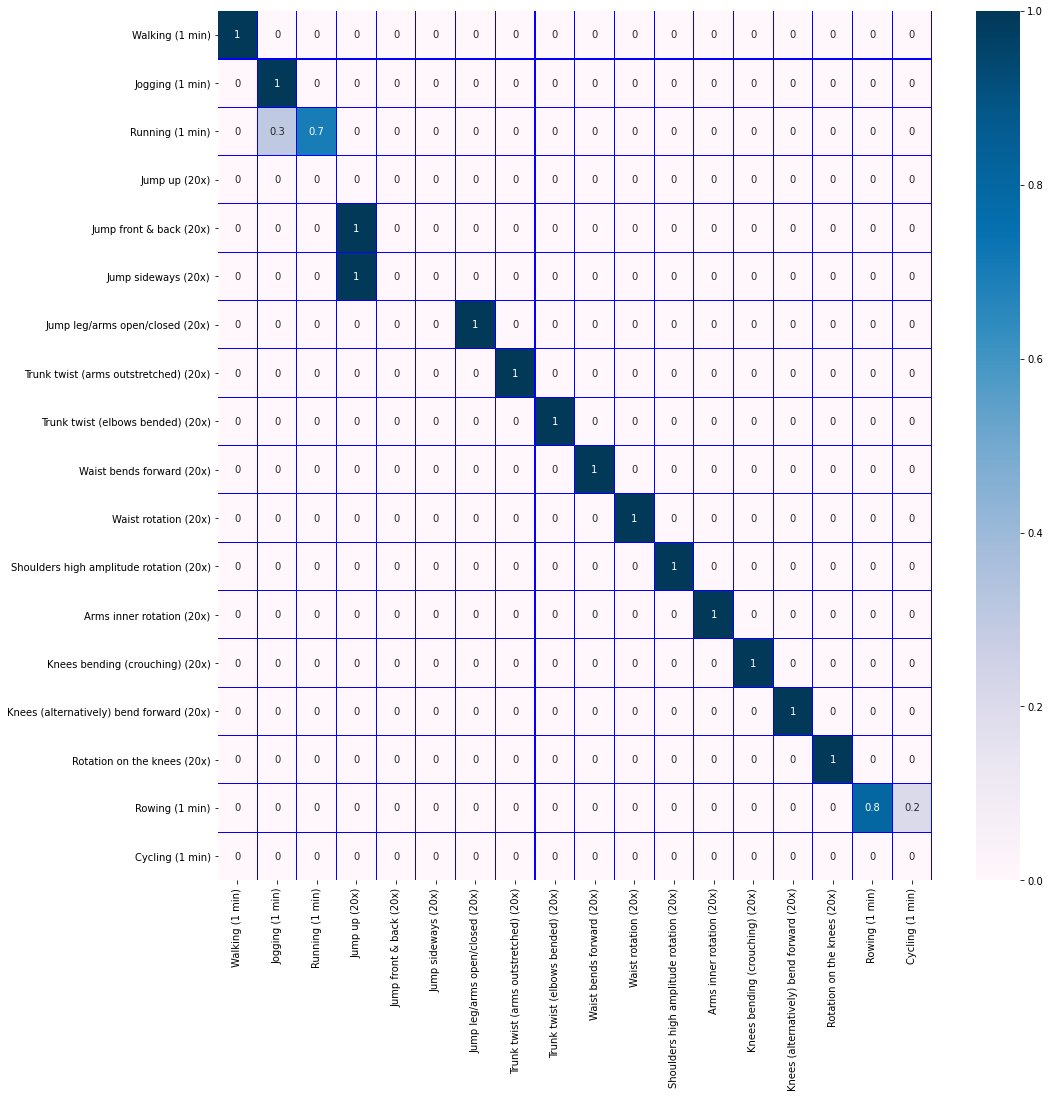

TEST SUBJECTS :  {7}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Epoch 1/100
57/57 [==============================] - 16s 273ms/step - loss: 3.4342 - accuracy: 0.0632 - val_loss: 3.4447 - val_accuracy: 0.0370
Epoch 2/100
57/57 [==============================] - 13s 222ms/step - loss: 3.2270 - accuracy: 0.0999 - val_loss: 2.9952 - val_accuracy: 0.1432
Epoch 3/100
57/57 [==============================] - 13s 225ms/step - loss: 2.4583 - accuracy: 0.2345 - val_loss: 2.4496 - val_accuracy: 0.2667
Epoch 4/100
57/57 [==============================] - 13s 223ms/step - loss: 1.9237 - accuracy: 0.3526 - val_loss: 2.2521 - val_accuracy: 0.3531
Epoch 5/100
57/57 [==============================] - 13s 224ms/step - loss: 1.6921 - accuracy: 0.4055 - val_loss: 2.7678 - val_accuracy: 0.2938
Epoch 6/100
57/57 [==============================] - 13s 225ms/step - loss: 1.5795 - accuracy: 0.4330 - val_loss: 1.7870 - val_accuracy: 0.4148
Epoch 7/100
57/57 [=====================

/home/agency/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1945: UserWarning: labels size, 28, does not match size of target_names, 33
  warnings.warn(


                                                          precision    recall  f1-score   support

                                         Walking (1 min)       1.00      1.00      1.00         4
                                         Jogging (1 min)       1.00      1.00      1.00         5
                                         Running (1 min)       1.00      1.00      1.00         8
                                           Jump up (20x)       1.00      0.00      0.00         1
                                 Jump front & back (20x)       0.67      1.00      0.80         2
                                     Jump sideways (20x)       1.00      1.00      1.00         2
                         Jump leg/arms open/closed (20x)       1.00      1.00      1.00         4
                                         Jump rope (20x)       1.00      1.00      1.00         3
                   Trunk twist (arms outstretched) (20x)       1.00      1.00      1.00         4
                   

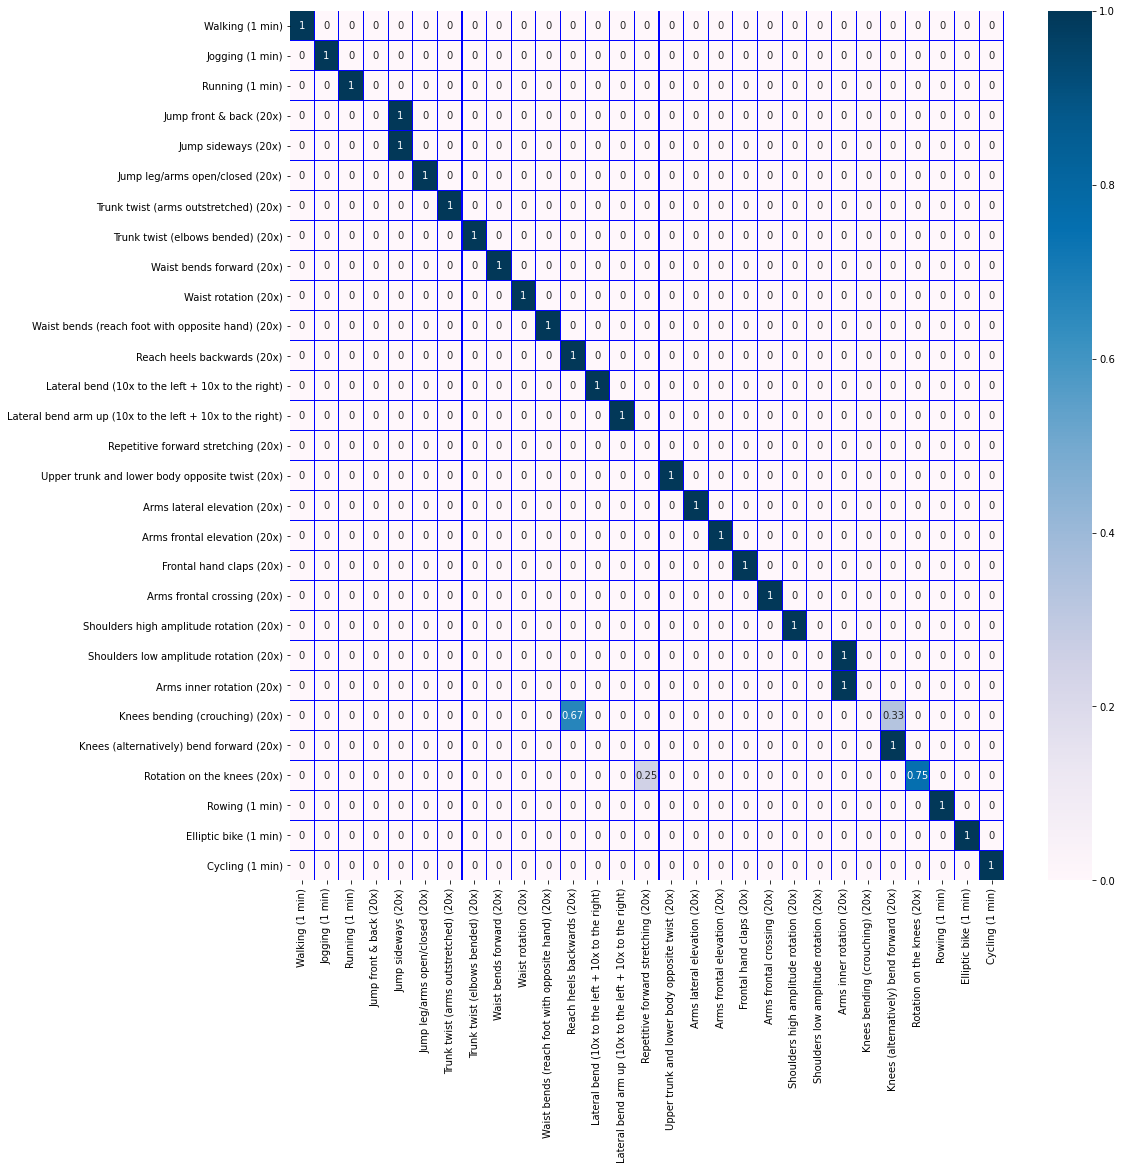

TEST SUBJECTS :  {8}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Epoch 1/100
55/55 [==============================] - 15s 277ms/step - loss: 3.2356 - accuracy: 0.0989 - val_loss: 2.8807 - val_accuracy: 0.0563
Epoch 2/100
55/55 [==============================] - 12s 225ms/step - loss: 2.5459 - accuracy: 0.1841 - val_loss: 2.3467 - val_accuracy: 0.2046
Epoch 3/100
55/55 [==============================] - 12s 223ms/step - loss: 1.9508 - accuracy: 0.3313 - val_loss: 2.0839 - val_accuracy: 0.2302
Epoch 4/100
55/55 [==============================] - 12s 225ms/step - loss: 1.5907 - accuracy: 0.4379 - val_loss: 1.9437 - val_accuracy: 0.2916
Epoch 5/100
55/55 [==============================] - 12s 224ms/step - loss: 1.2812 - accuracy: 0.5166 - val_loss: 1.9272 - val_accuracy: 0.3836
Epoch 6/100
55/55 [==============================] - 12s 225ms/step - loss: 1.1158 - accuracy: 0.5877 - val_loss: 1.8394 - val_accuracy: 0.4092
Epoch 7/100
55/55 [=====================

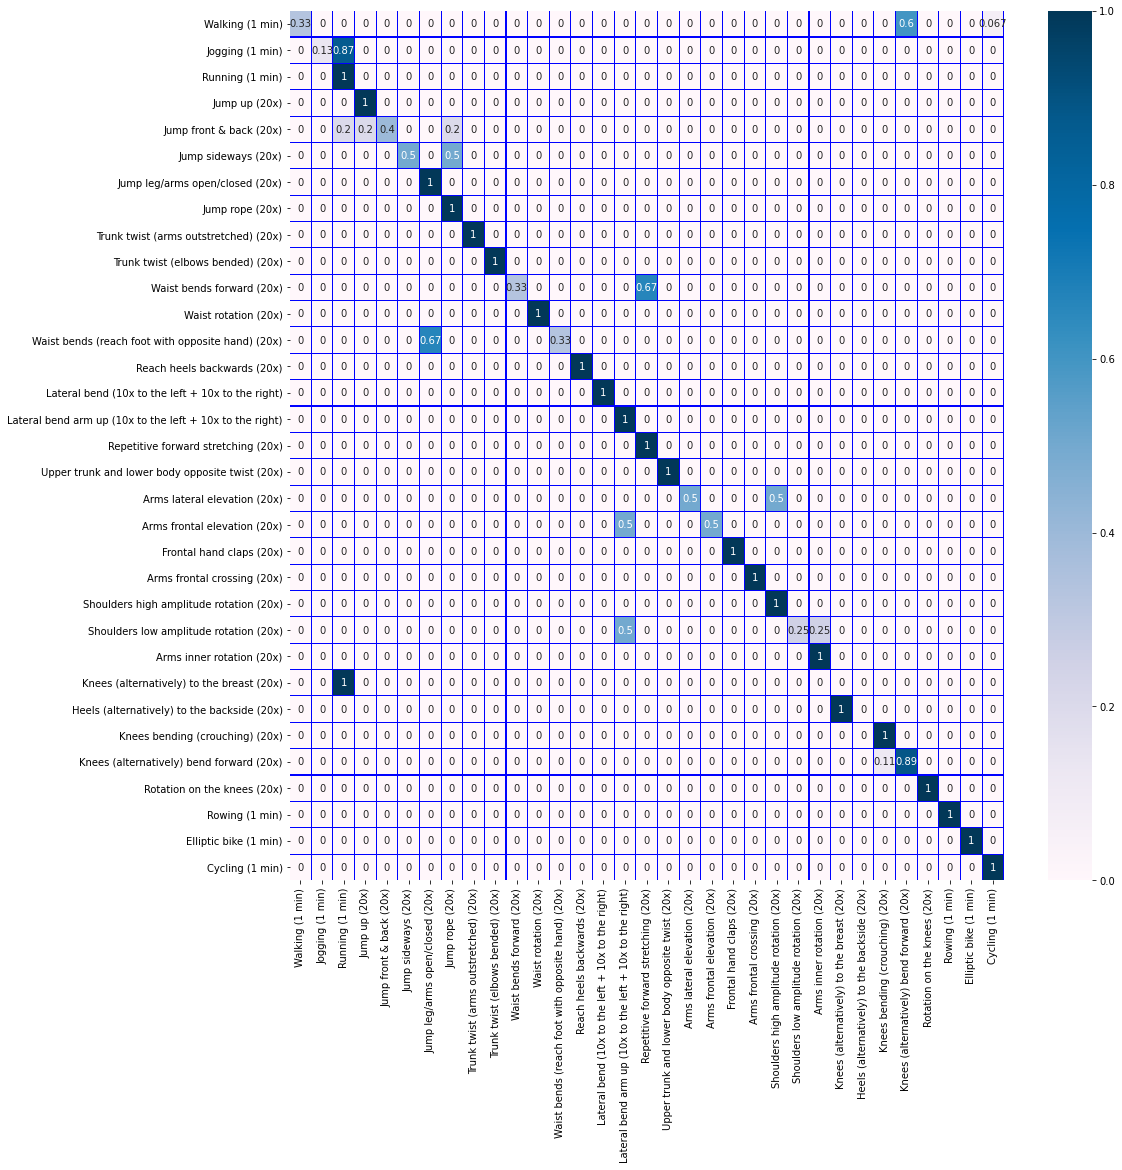

TEST SUBJECTS :  {9}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17}
Epoch 1/100
55/55 [==============================] - 15s 274ms/step - loss: 2.9634 - accuracy: 0.1727 - val_loss: 2.4675 - val_accuracy: 0.2196
Epoch 2/100
55/55 [==============================] - 12s 222ms/step - loss: 1.7005 - accuracy: 0.4412 - val_loss: 1.9153 - val_accuracy: 0.4444
Epoch 3/100
55/55 [==============================] - 12s 224ms/step - loss: 1.2461 - accuracy: 0.5790 - val_loss: 1.8260 - val_accuracy: 0.4677
Epoch 4/100
55/55 [==============================] - 12s 222ms/step - loss: 0.8776 - accuracy: 0.6967 - val_loss: 1.3804 - val_accuracy: 0.5659
Epoch 5/100
55/55 [==============================] - 12s 222ms/step - loss: 0.6273 - accuracy: 0.7801 - val_loss: 1.2026 - val_accuracy: 0.6537
Epoch 6/100
55/55 [==============================] - 12s 221ms/step - loss: 0.4566 - accuracy: 0.8446 - val_loss: 1.4816 - val_accuracy: 0.6227
Epoch 7/100
55/55 [=====================

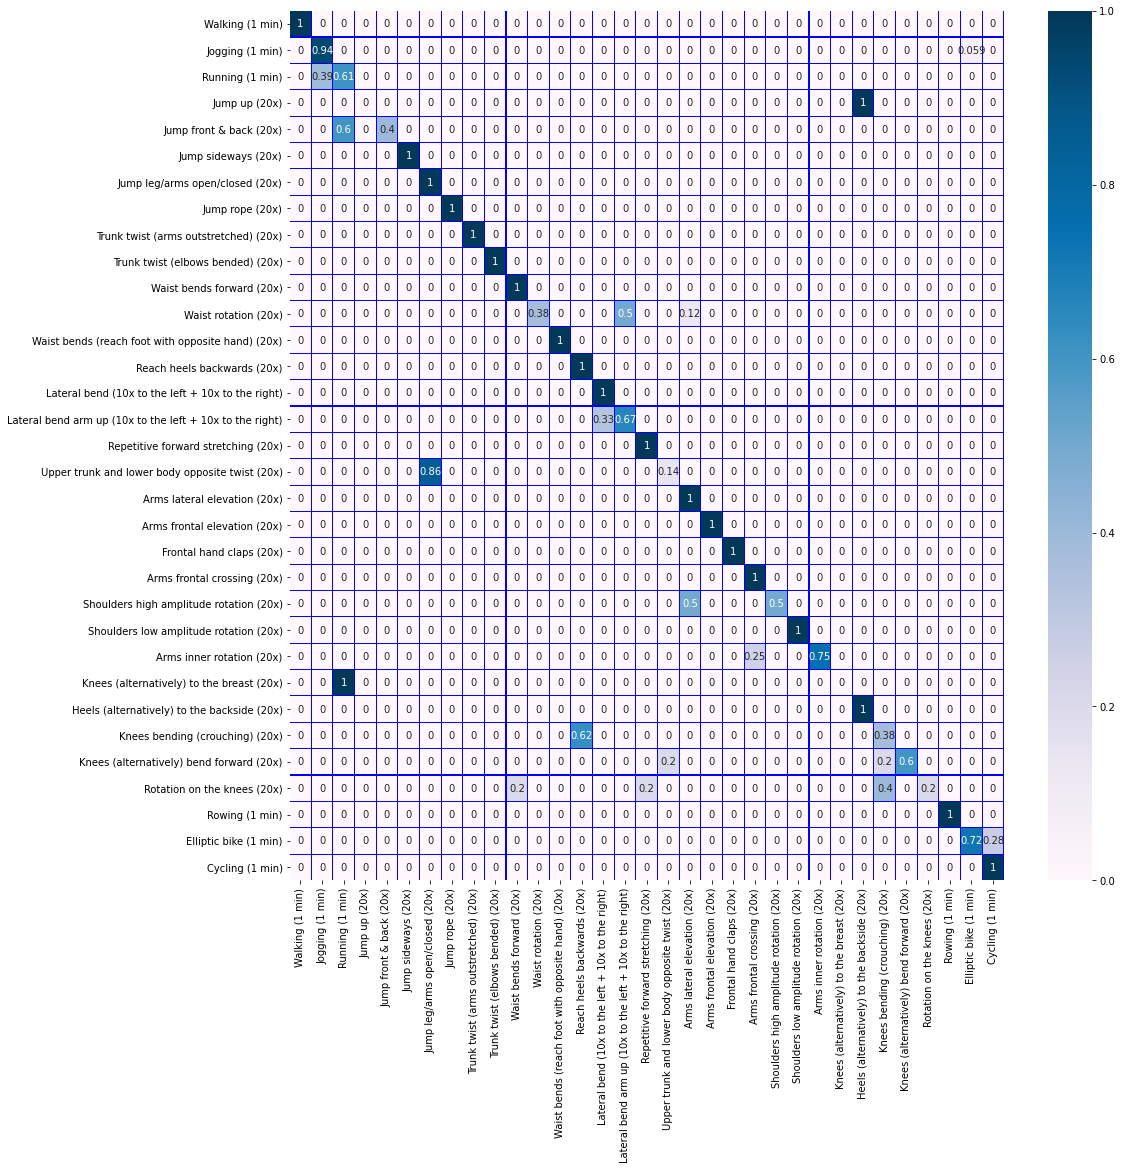

TEST SUBJECTS :  {10}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17}
Epoch 1/100
55/55 [==============================] - 15s 268ms/step - loss: 3.4337 - accuracy: 0.0767 - val_loss: 3.3825 - val_accuracy: 0.0517
Epoch 2/100
55/55 [==============================] - 11s 208ms/step - loss: 2.2750 - accuracy: 0.3220 - val_loss: 2.1730 - val_accuracy: 0.3282
Epoch 3/100
55/55 [==============================] - 11s 208ms/step - loss: 1.4039 - accuracy: 0.5065 - val_loss: 1.8419 - val_accuracy: 0.4160
Epoch 4/100
55/55 [==============================] - 11s 208ms/step - loss: 1.0838 - accuracy: 0.5981 - val_loss: 1.8867 - val_accuracy: 0.4651
Epoch 5/100
55/55 [==============================] - 11s 208ms/step - loss: 0.9367 - accuracy: 0.6510 - val_loss: 1.5625 - val_accuracy: 0.5220
Epoch 6/100
55/55 [==============================] - 12s 223ms/step - loss: 0.7415 - accuracy: 0.7320 - val_loss: 1.7767 - val_accuracy: 0.5556
Epoch 7/100
55/55 [=====================

/home/agency/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1945: UserWarning: labels size, 32, does not match size of target_names, 33
  warnings.warn(


                                                          precision    recall  f1-score   support

                                         Walking (1 min)       1.00      1.00      1.00        26
                                         Jogging (1 min)       1.00      0.59      0.74        17
                                         Running (1 min)       0.72      1.00      0.84        18
                                           Jump up (20x)       1.00      0.00      0.00         2
                                 Jump front & back (20x)       0.62      1.00      0.77         5
                                     Jump sideways (20x)       1.00      1.00      1.00         6
                         Jump leg/arms open/closed (20x)       1.00      1.00      1.00         6
                                         Jump rope (20x)       1.00      1.00      1.00         2
                   Trunk twist (arms outstretched) (20x)       1.00      1.00      1.00        11
                   

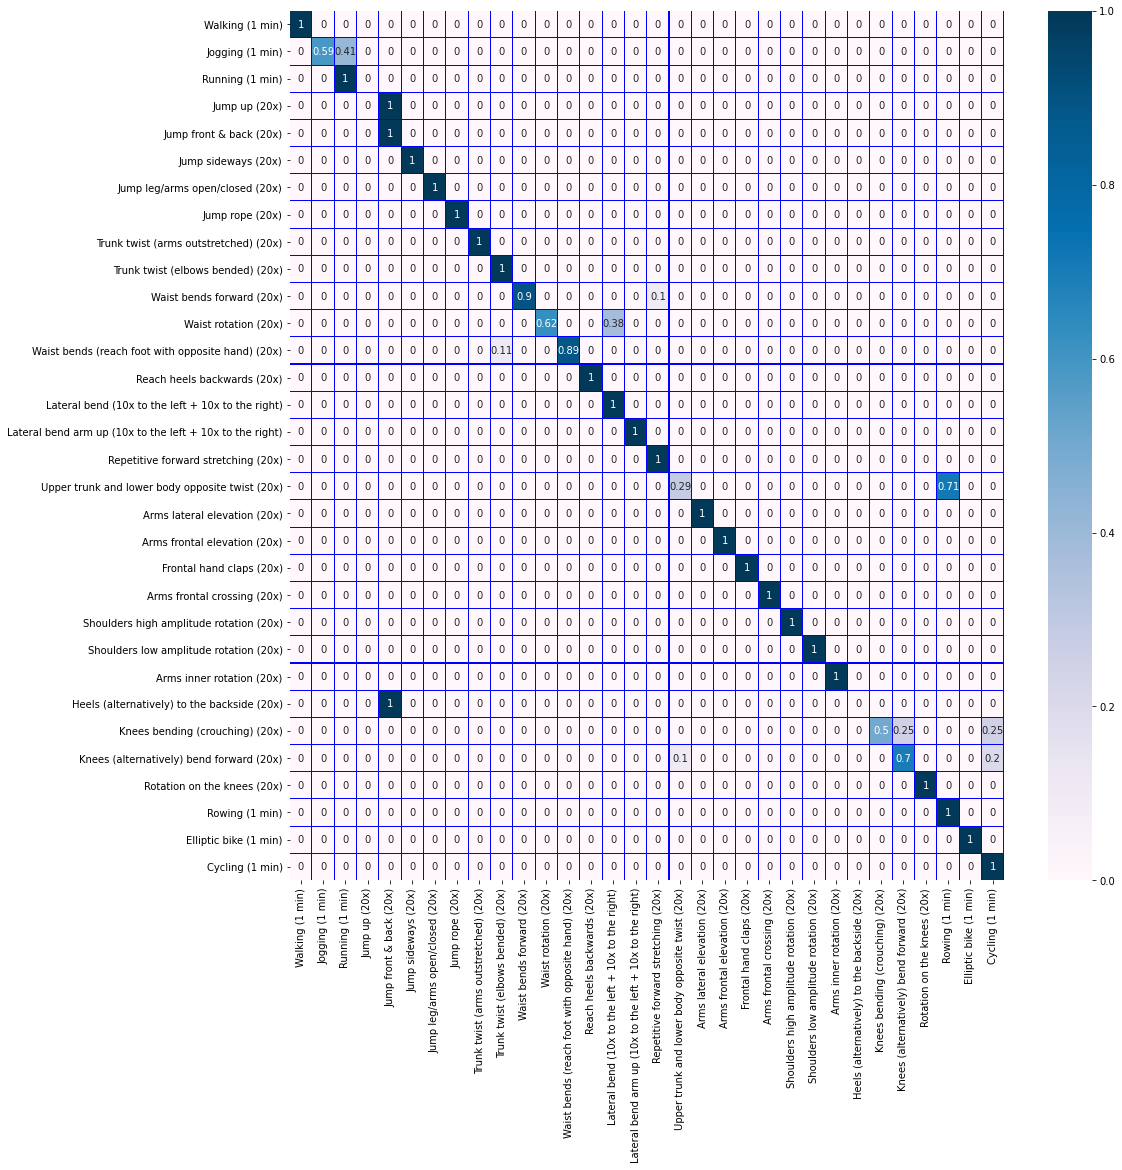

TEST SUBJECTS :  {11}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17}
Epoch 1/100
55/55 [==============================] - 15s 275ms/step - loss: 3.2840 - accuracy: 0.1034 - val_loss: 2.9920 - val_accuracy: 0.0698
Epoch 2/100
55/55 [==============================] - 12s 223ms/step - loss: 2.6174 - accuracy: 0.2011 - val_loss: 2.7369 - val_accuracy: 0.1499
Epoch 3/100
55/55 [==============================] - 12s 224ms/step - loss: 2.1292 - accuracy: 0.2750 - val_loss: 2.5125 - val_accuracy: 0.1525
Epoch 4/100
55/55 [==============================] - 12s 225ms/step - loss: 1.8881 - accuracy: 0.3230 - val_loss: 2.2931 - val_accuracy: 0.2274
Epoch 5/100
55/55 [==============================] - 12s 223ms/step - loss: 1.6429 - accuracy: 0.4049 - val_loss: 2.6761 - val_accuracy: 0.2248
Epoch 6/100
55/55 [==============================] - 12s 225ms/step - loss: 1.6005 - accuracy: 0.4201 - val_loss: 2.7972 - val_accuracy: 0.2016
Epoch 7/100
55/55 [=====================

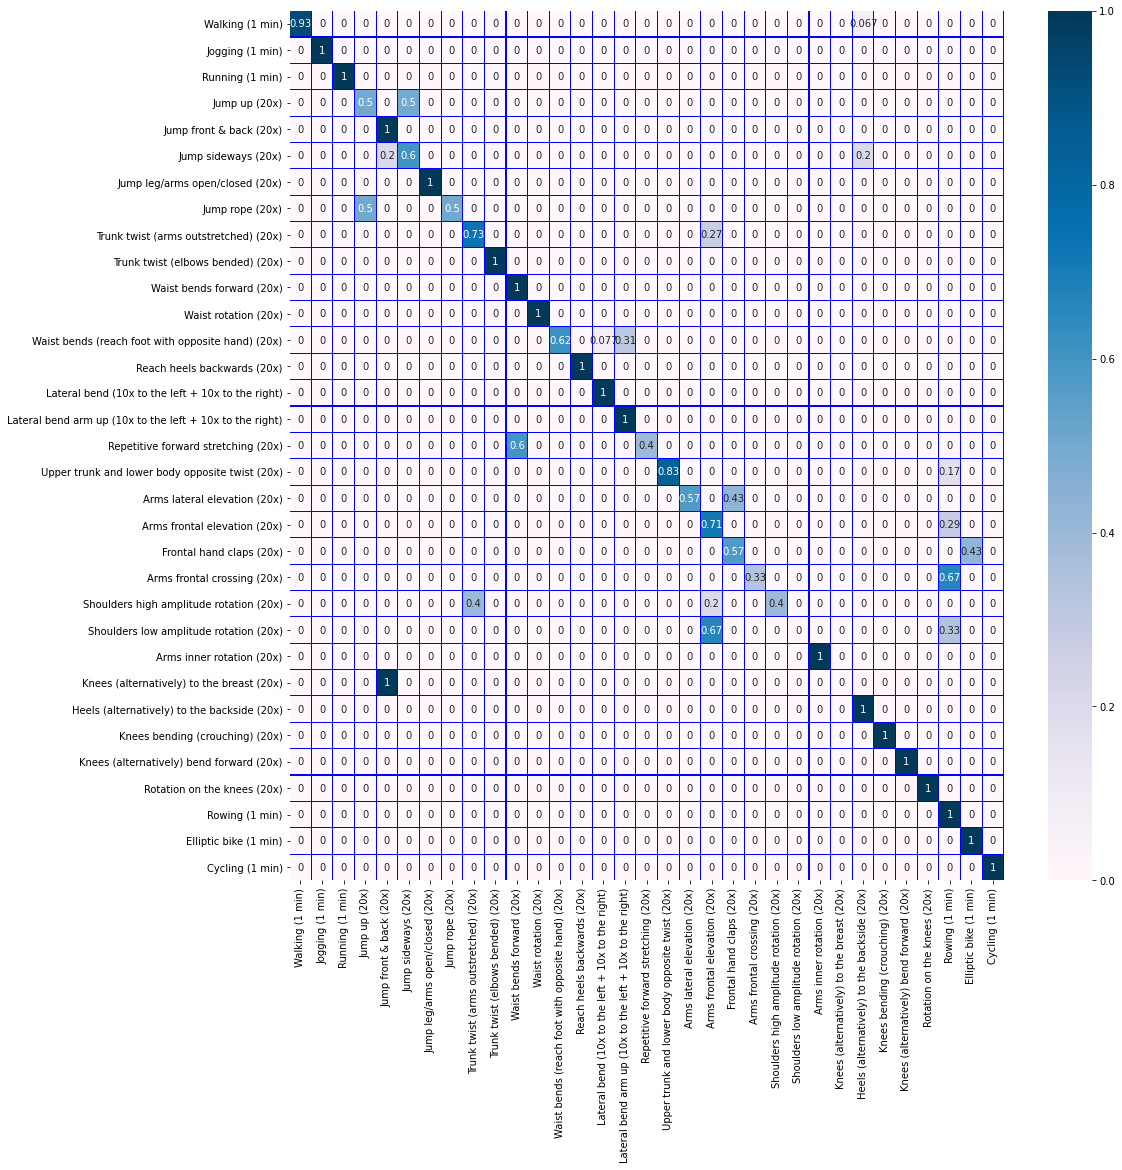

TEST SUBJECTS :  {12}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17}
Epoch 1/100
55/55 [==============================] - 15s 275ms/step - loss: 3.4415 - accuracy: 0.0617 - val_loss: 3.4348 - val_accuracy: 0.0541
Epoch 2/100
55/55 [==============================] - 12s 220ms/step - loss: 3.3758 - accuracy: 0.0734 - val_loss: 3.4317 - val_accuracy: 0.0567
Epoch 3/100
55/55 [==============================] - 12s 221ms/step - loss: 3.0118 - accuracy: 0.1245 - val_loss: 2.8540 - val_accuracy: 0.0954
Epoch 4/100
55/55 [==============================] - 12s 216ms/step - loss: 2.6970 - accuracy: 0.1543 - val_loss: 2.8005 - val_accuracy: 0.0928
Epoch 5/100
55/55 [==============================] - 12s 211ms/step - loss: 2.3902 - accuracy: 0.2134 - val_loss: 2.6352 - val_accuracy: 0.1160
Epoch 6/100
55/55 [==============================] - 12s 217ms/step - loss: 2.1243 - accuracy: 0.2767 - val_loss: 2.6715 - val_accuracy: 0.1005
Epoch 7/100
55/55 [=====================

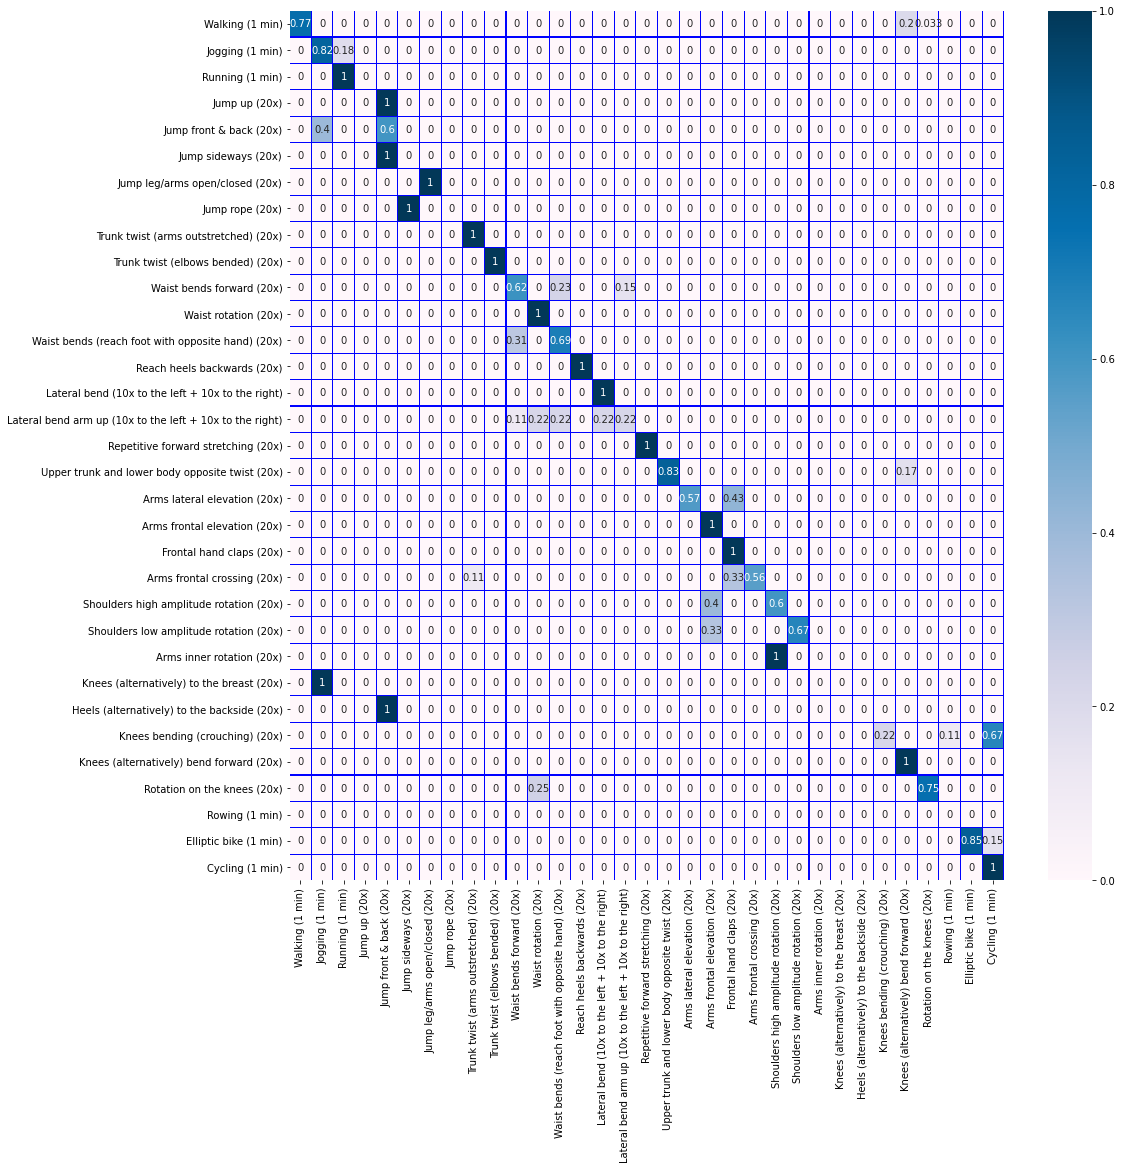

TEST SUBJECTS :  {13}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17}
Epoch 1/100
57/57 [==============================] - 16s 275ms/step - loss: 3.2993 - accuracy: 0.1044 - val_loss: 3.3906 - val_accuracy: 0.0498
Epoch 2/100
57/57 [==============================] - 13s 223ms/step - loss: 2.0950 - accuracy: 0.3261 - val_loss: 2.2626 - val_accuracy: 0.2289
Epoch 3/100
57/57 [==============================] - 13s 223ms/step - loss: 1.4883 - accuracy: 0.4892 - val_loss: 2.5568 - val_accuracy: 0.2313
Epoch 4/100
57/57 [==============================] - 13s 225ms/step - loss: 1.1660 - accuracy: 0.5817 - val_loss: 1.7300 - val_accuracy: 0.4403
Epoch 5/100
57/57 [==============================] - 13s 222ms/step - loss: 0.9531 - accuracy: 0.6362 - val_loss: 1.8504 - val_accuracy: 0.4776
Epoch 6/100
57/57 [==============================] - 13s 223ms/step - loss: 0.7651 - accuracy: 0.7112 - val_loss: 1.6580 - val_accuracy: 0.5522
Epoch 7/100
57/57 [=====================

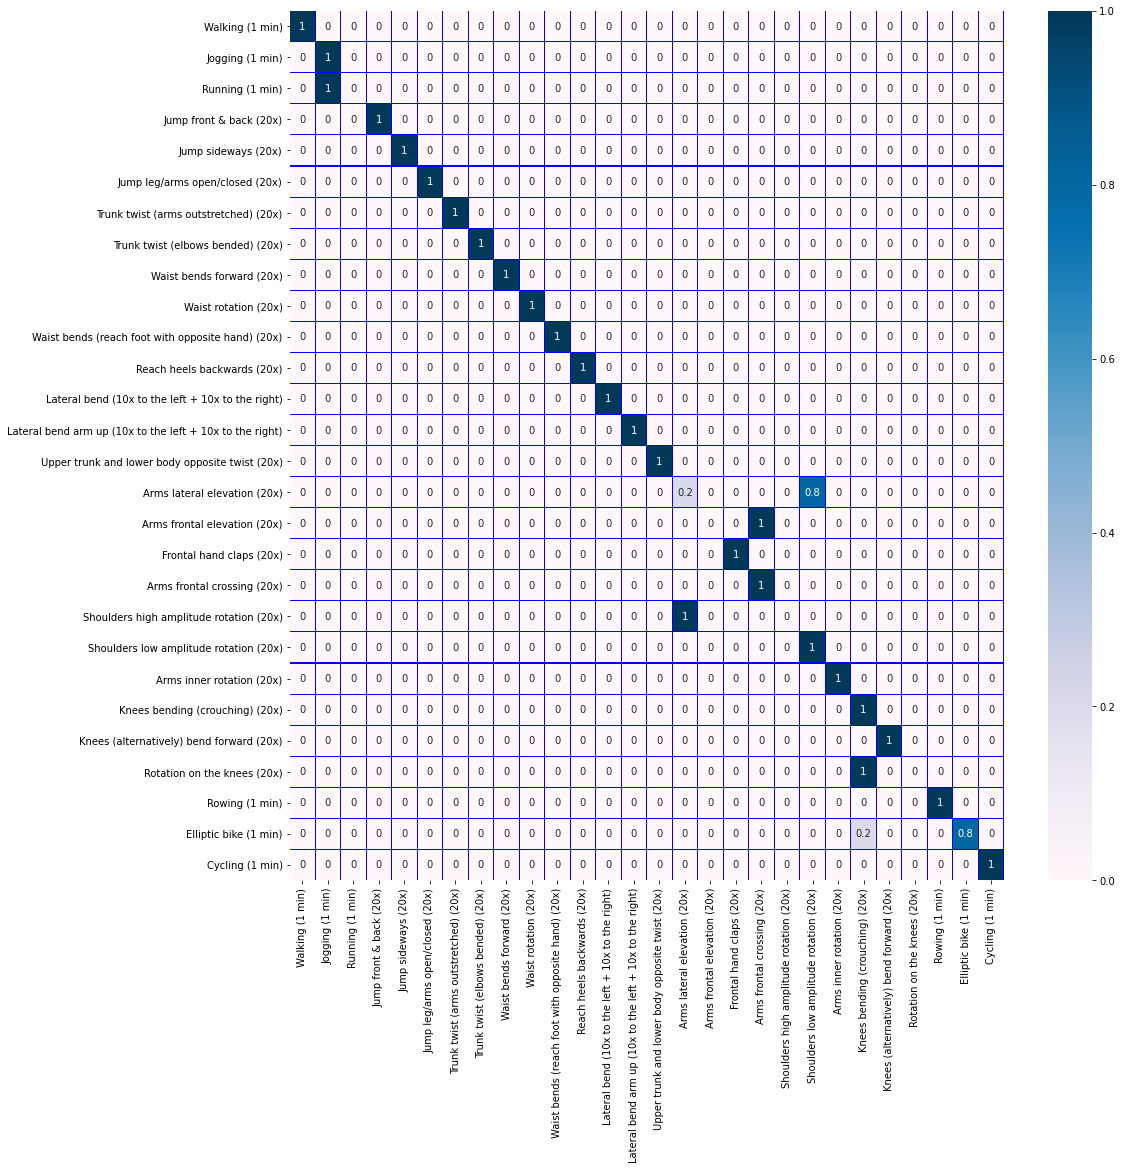

TEST SUBJECTS :  {14}
TRAIN SUBJECTS :  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17}
Epoch 1/100
53/55 [===========================>..] - ETA: 0s - loss: 3.3065 - accuracy: 0.1117

In [ ]:
run_experiment(df=df.copy(), FEATURES=FEATURES, WINDOW_SIZE=750, STRIDE=250, BATCH_SIZE=64, N_WINDOW=15, N_TIMESTEP=50, sub_start=6)

In [ ]:
run_experiment(df=df.copy(), FEATURES=FEATURES, WINDOW_SIZE=750, STRIDE=250, BATCH_SIZE=64, N_WINDOW=15, N_TIMESTEP=50, sub_start=1)

TEST SUBJECTS :  {1}
TRAIN SUBJECTS :  {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Epoch 1/80
61/61 - 13s - loss: 3.3257 - accuracy: 0.0961
Epoch 2/80


In [ ]:
run_experiment(df=df.copy(), FEATURES=FEATURES, WINDOW_SIZE=500, STRIDE=250, BATCH_SIZE=64, N_WINDOW=10, N_TIMESTEP=50, sub_start=1)